In [1]:
#!pip install fiona
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.widgets import Slider
import numpy as np
import fiona
import shapely
from shapely.geometry import shape,mapping, Point, Polygon, MultiPolygon
import networkx as nx
import pickle
from ipywidgets import interact, widgets

In [18]:
def matching_prob_t_grad(path='../data/', shp_file='../data/taxi_zones/taxi_zones.shp', delta_t = 15, t=32):

    #df = pd.read_csv(path + f'matching_prob_{delta_t}_plot.csv') #(, 263)
    df = pd.read_csv('../data/matching_prob_15_plot.csv')
    data = np.asarray(df)[t-1,:]
    greater = [] # prob greater than 1
    equal = []
    smaller = [] # prob smaller than 1
    prob_0 = []
    dropoff_0 = []

    max_color = max(data)
    norm_red = mpl.colors.Normalize(1, vmax=max_color, clip=False)
    norm_blue = mpl.colors.Normalize(min(data[data!=0]), vmax=1, clip=False)
    mapper_red = mpl.cm.ScalarMappable(norm=norm_red, cmap=mpl.cm.Reds)
    mapper_blue = mpl.cm.ScalarMappable(norm=norm_blue, cmap=mpl.cm.Blues_r)

    for i in range(len(data)):
        if data[i] > 1:
            greater.append(i+1)
        elif data[i] == 1:
            equal.append(i+1)
        elif 0 < data[i] < 1:
            smaller.append(i+1)
        elif data[i] == 0:
            prob_0.append(i+1)
        else:
            dropoff_0.append(i+1)


    G = nx.DiGraph()
    taxi_zones = fiona.open(shp_file)
    color_white = []
    color_red = []
    color_blue = []

    for i in range(len(taxi_zones)):
        zone = taxi_zones[i]
        i = int(zone['id']) + 1
        shape = shapely.geometry.asShape(zone['geometry'])
        center = shape.centroid.coords[0]
        G.add_node(i,pos=center) # add node with position
        if (i in greater):
            color_red.append(mapper_red.to_rgba(data[i-1]))
        elif (i in equal):
            color_white.append('white')
        elif (i in smaller):
            color_blue.append(mapper_blue.to_rgba(data[i-1]))

    p = nx.get_node_attributes(G,'pos')
    fig = plt.figure(3,figsize=(30,30)) 
    nx.draw_networkx_nodes(G, nodelist = greater, pos=p, node_color=color_red, node_size=500, alpha = 1, edgecolors = 'black', linewidths=1, label='prob > 1')
    nx.draw_networkx_nodes(G, nodelist = equal, pos=p, node_color=color_white, node_size=500, alpha = 1, edgecolors = 'black', linewidths=1, label = 'prob = 1')
    nx.draw_networkx_nodes(G, nodelist = smaller, pos=p, node_color=color_blue, node_size=500, alpha = 1, edgecolors = 'black', linewidths=1, label='0 < porb < 1')
    nx.draw_networkx_nodes(G, nodelist = prob_0, pos=p, node_color='gray', node_size=500, alpha = 1, edgecolors = 'black', linewidths=1, label='porb = 0')
    nx.draw_networkx_nodes(G, nodelist = dropoff_0, pos=p, node_color='gray', node_size=500, alpha = 1, edgecolors = 'black', linewidths=4, label='no dropoff')
    nx.draw_networkx_labels(G, pos=p, font_size=10)


    fig.suptitle(f'Matching Probability for Taxi Zones at t = {t}, delta_t = {delta_t}', fontsize=30, y=0.9)
    plt.savefig('matching_prob_grad.png', bbox_inches = 'tight')
    plt.legend()
    plt.show()

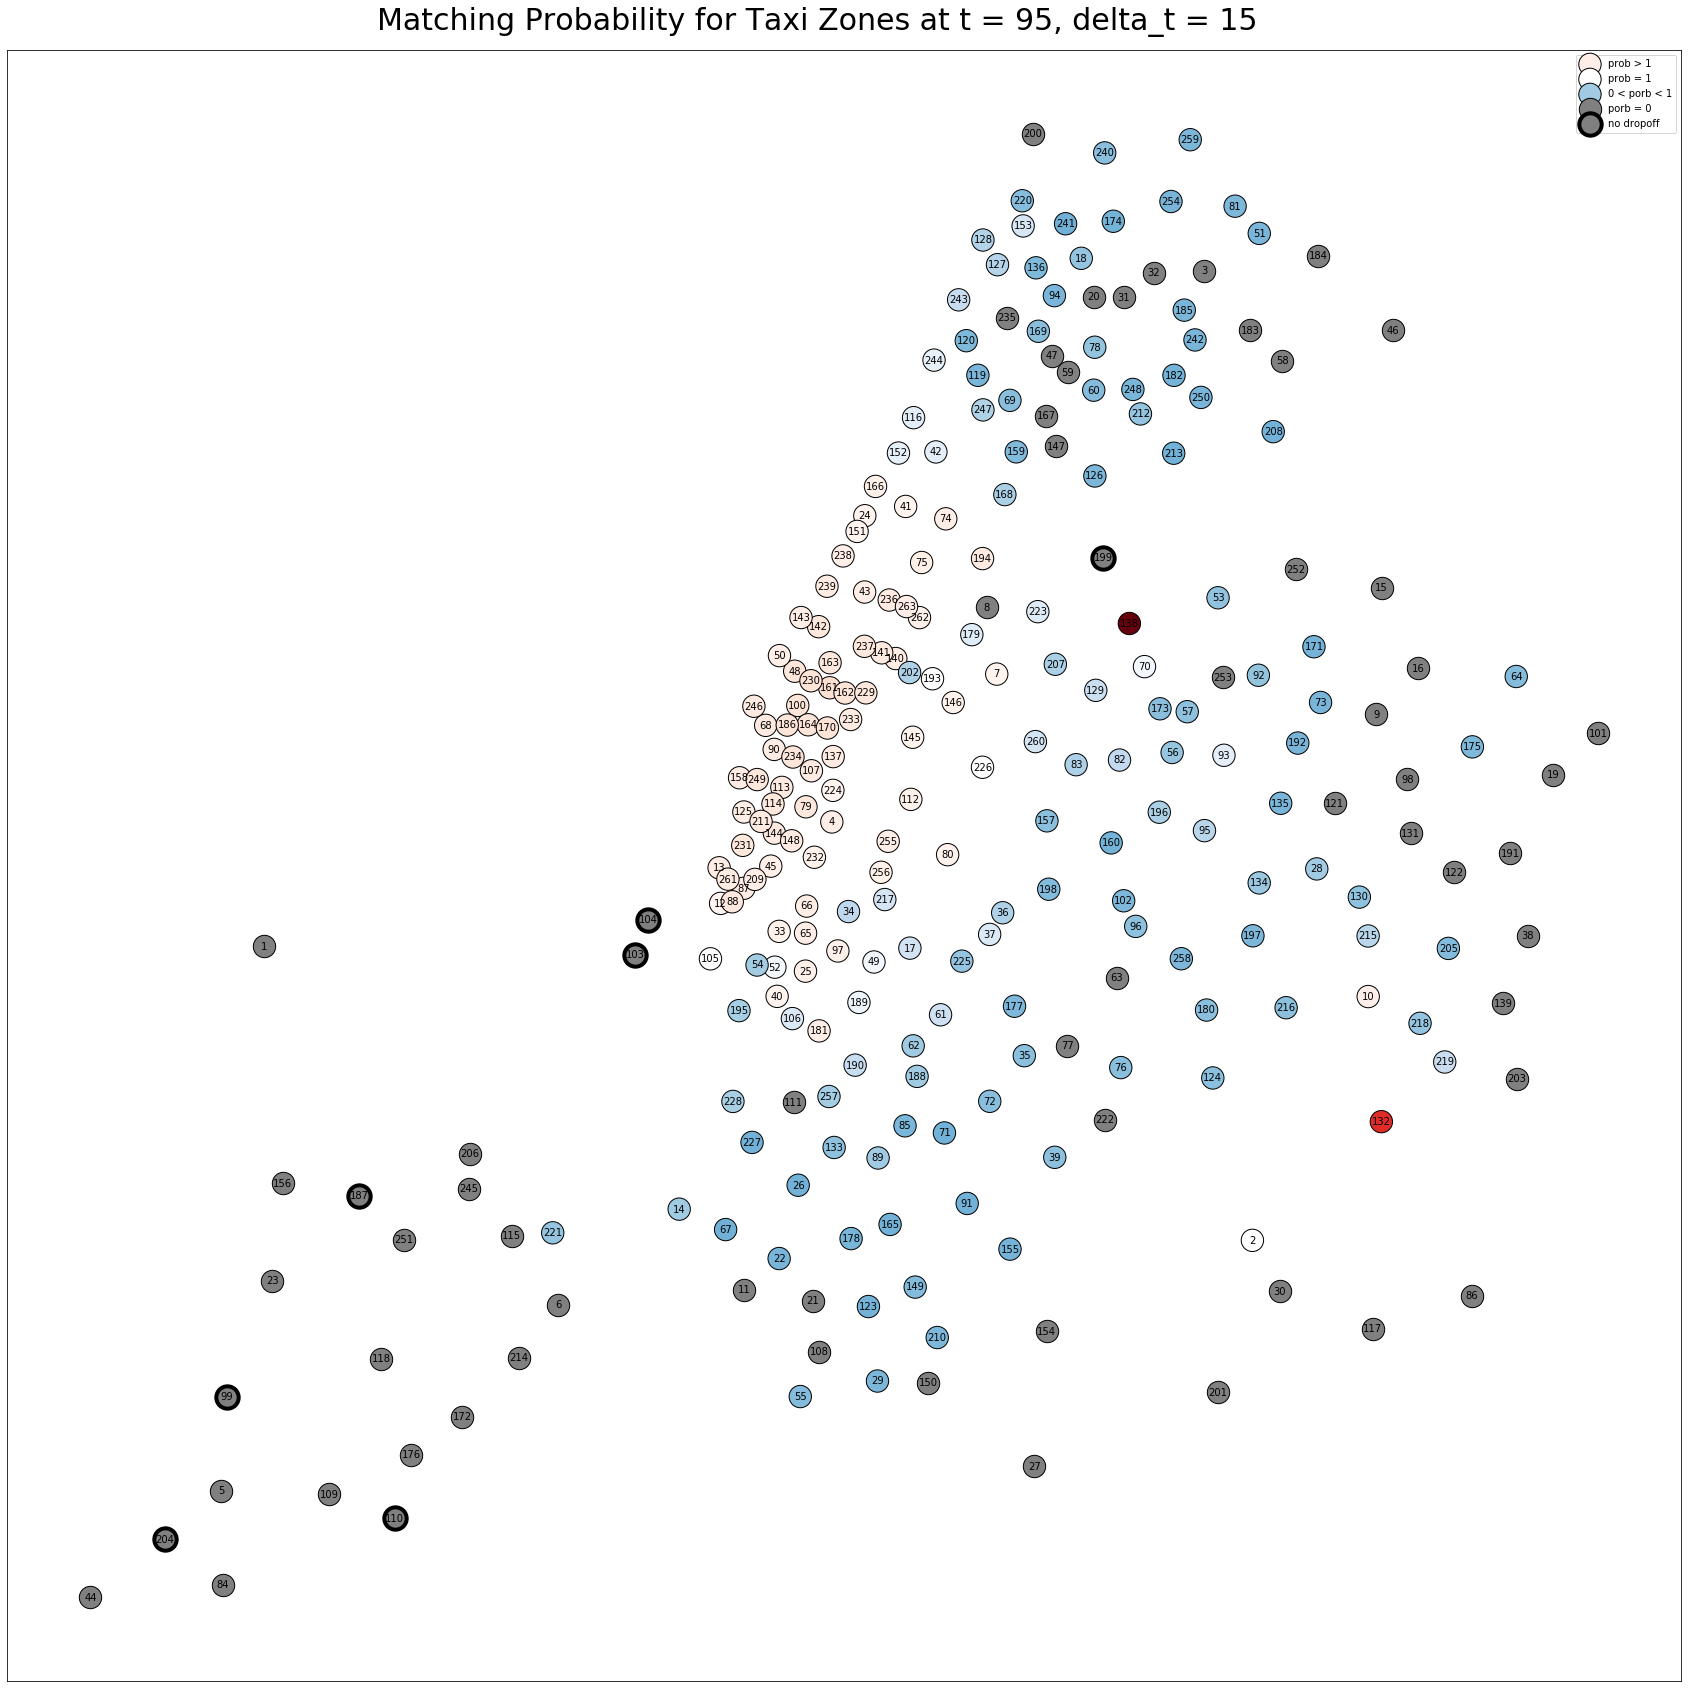

In [19]:
matching_prob_t_grad(path='', shp_file='../data/taxi_zones/taxi_zones.shp', delta_t = 15, t=95)

In [20]:
def interactive_plot(delta_t_):
    interact(matching_prob_t_grad, delta_t = widgets.RadioButtons(options=[delta_t_], value=delta_t_), t=widgets.IntSlider(min=0,max=int(1440/delta_t_-1),step=1,value=0))


In [21]:
interactive_plot(30)

interactive(children=(Text(value='../data/', description='path'), Text(value='../data/taxi_zones/taxi_zones.sh…